# Setup


In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import os
import cv2
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
!rm -rf sample_data
!rm -rf data
!mkdir data
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c ppke-itk-neural-networks-2022-challenge
!unzip ppke-itk-neural-networks-2022-challenge.zip -d data

!rm ppke-itk-neural-networks-2022-challenge.zip
!rm data/sample_submission.txt

!mv data/db_chlorella_renamed_TEST data/test
!mv data/db_chlorella_renamed_TRAIN data/train

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyperparameters and Classifier

In [5]:
# TODO: Find the best hyperparameters
LEARNING_RATE = 0.00001
BATCH_SIZE = 16
EPOCH_NUM = 6

# TODO: Simplifly The Model
CLASSIFIER = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096, bias=True)),
    ('relu1', nn.ReLU(inplace=True)),
    ('drop1', nn.Dropout(p=0.5, inplace=False)),
    ('fc2', nn.Linear(4096, 4096, bias=True)),
    ('relu2', nn.ReLU(inplace=True)),
    ('drop2', nn.Dropout(p=0.5, inplace=False)),
    ('fc3', nn.Linear(4096, 8, bias=True)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

# Create DataSet

In [6]:
def load_train(path, start=0, stop=1):

  images = []
  labels = []
  ids = []

  classes = sorted(os.listdir(path))
  for idx in range(len(classes)):

    even_files = sorted(os.listdir(os.path.join(path, classes[idx])))[::2]
    odd_files = sorted(os.listdir(os.path.join(path, classes[idx])))[1::2]

    bottom_limit = int(len(even_files)*start)
    top_limit = int(len(even_files)*stop)

    for n, (amp_file, phase_file) in enumerate(zip(even_files, odd_files)):
      if bottom_limit <= n and n < top_limit:

        amp_path = os.path.join(path, classes[idx], amp_file)
        phase_path = os.path.join(path, classes[idx], phase_file)

        paths = (amp_path, phase_path)
        label = idx
        id = amp_file.split('_')[0]

        images.append(paths)
        labels.append(label)
        ids.append(id)

  return images, labels, ids

In [7]:
def load_test(path):

  images = []
  labels = []
  ids = []

  even_files = sorted(os.listdir(path))[::2]
  odd_files = sorted(os.listdir(path))[1::2]

  for amp_file, phase_file in zip(even_files, odd_files):

    amp_path = os.path.join(path, amp_file)
    phase_path = os.path.join(path, phase_file)

    paths = (amp_path, phase_path)
    label = -1
    id = amp_file.split('_')[0]

    images.append(paths)
    labels.append(label)
    ids.append(id)

  return images, labels, ids

In [8]:
class CTDataset(Dataset):
  def __init__(self, filepath, loader="train", transform=transforms.ToTensor()):
    if loader == "train":
      self.x, self.y, self.id = load_train(filepath, 0, 0.85)
    if loader == "valid":
      self.x, self.y, self.id = load_train(filepath, 0.85, 1)
    if loader == "test":
      self.x, self.y, self.id = load_test(filepath)
    self.transform = transform
  def __len__(self):
    return len(self.id)
  def __getitem__(self, idx):
    image_path = self.x[idx]

    amp_image = torch.tensor(cv2.imread(image_path[0], 0))
    phase_image = torch.tensor(cv2.imread(image_path[1], 0))
    _, max = torch.max(torch.stack((amp_image, phase_image)), axis=0)

    images = torch.stack((amp_image, phase_image, max)).to(torch.float)
    trans_image = self.transform(images)

    return trans_image, self.y[idx], self.id[idx]

In [9]:
# TODO: Find the best transformations
training_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5,), std=(0.5,)) # TODO: Calculate
])

testing_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5,), std=(0.5,)) # TODO: Calculate
])

In [10]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [11]:
train_ds = CTDataset(train_dir, loader="train", transform=training_transforms)
valid_ds = CTDataset(train_dir, loader="valid", transform=testing_transforms)
test_ds = CTDataset(test_dir, loader="test", transform=testing_transforms)

* DataSet check



In [12]:
print(f'Train Dataset size: {len(train_ds)}')
for iclass in range(8):
  sum = 0
  for i in train_ds:
    if i[1] == iclass:
      sum += 1
  print(f' - class {iclass+1}: {sum}')

print(f'Valid Dataset size: {len(valid_ds)}')
for iclass in range(8):
  sum = 0
  for i in valid_ds:
    if i[1] == iclass:
      sum += 1
  print(f' - class {iclass+1}: {sum}')

print(f'Test Dataset size: {len(test_ds)}')

Train Dataset size: 1262
 - class 1: 689
 - class 2: 104
 - class 3: 42
 - class 4: 74
 - class 5: 21
 - class 6: 16
 - class 7: 164
 - class 8: 152
Valid Dataset size: 227
 - class 1: 122
 - class 2: 19
 - class 3: 8
 - class 4: 14
 - class 5: 4
 - class 6: 3
 - class 7: 30
 - class 8: 27
Test Dataset size: 262


Original Train Dataset size: 1489

*   811
*   123
*   50
*   88
*   25
*   19
*   194
*   179




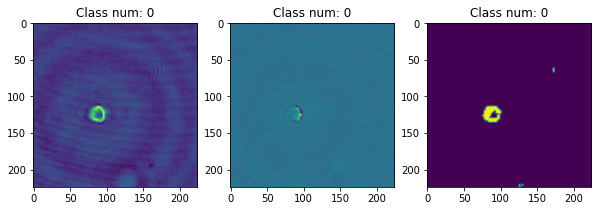

In [16]:
train_chlorella_num = 0
chlorella_img, chorella_label, chorella_id = train_ds[train_chlorella_num]

fig = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(chlorella_img[i])
  plt.title(f'Class num: {chorella_label}')
plt.show()

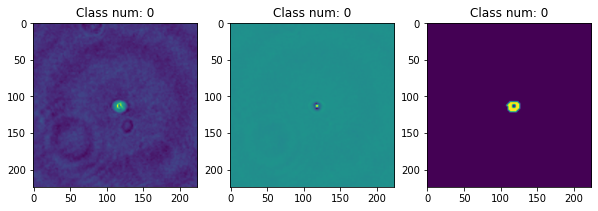

In [14]:
valid_chlorella_num = 0
chlorella_img, chorella_label, chorella_id = valid_ds[valid_chlorella_num]

fig = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(chlorella_img[i])
  plt.title(f'Class num: {chorella_label}')
plt.show()

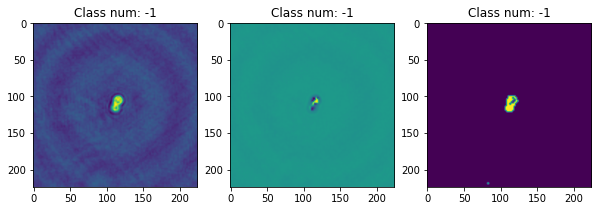

In [15]:
test_chlorella_num = 0
chlorella_img, chorella_label, chorella_id = test_ds[test_chlorella_num]

fig = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(chlorella_img[i])
  plt.title(f'Class num: {chorella_label}')
plt.show()

# Create DataLoader

In [17]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

* DataLoader check

In [ ]:
for i, (x, y, _ ) in enumerate(train_dl):
  print(f'Batch {i+1}')
  print(f' - x.shape: {x.shape}')
  print(f' - y.shape: {y.shape}')

# Create the Model

In [19]:
# Find better or create one
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [21]:
for parameter in model.parameters():
  parameter.requires_grad = False

model.classifier = CLASSIFIER

# Train the Model

In [23]:
# TODO: Check Handle right the unbalance dataset
def weight_calc(class_size):
  return 1 - ( class_size / len(train_ds) )
  
class_weights = [weight_calc(689),
                 weight_calc(104),
                 weight_calc(42),
                 weight_calc(74),
                 weight_calc(21),
                 weight_calc(16),
                 weight_calc(164),
                 weight_calc(152)]
                 
print(class_weights)

[0.4540412044374009, 0.9175911251980983, 0.9667194928684628, 0.9413629160063391, 0.9833597464342314, 0.9873217115689382, 0.8700475435816165, 0.8795562599049128]


In [25]:
criterion = nn.NLLLoss(weight=torch.tensor(class_weights).to(device))
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

In [26]:
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels, _ in iter(validateloader):

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [27]:
def train_classifier():

  print_every = 5

  steps = 0
  model.to(device)
  for epoch in range(EPOCH_NUM):    
    model.train()
    running_loss = 0
    for images, labels, _ in iter(train_dl):
      steps += 1
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
        
      running_loss += loss.item()
        
      if steps % print_every == 0:    
        model.eval() 
        
        with torch.no_grad():
          validation_loss, accuracy = validation(model, valid_dl, criterion)

        print("Epoch: {}/{} |".format(epoch+1, EPOCH_NUM), 
              "Training Loss: {:.3f} |".format(running_loss/print_every),
              "Validation Loss: {:.3f} |".format(validation_loss/len(valid_dl)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valid_dl)))
        running_loss = 0
        model.train()

  print("Traning Done!")            

In [28]:
train_classifier()

Epoch: 1/6 | Training Loss: 2.013 | Validation Loss: 1.985 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.944 | Validation Loss: 1.883 | Validation Accuracy: 0.562
Epoch: 1/6 | Training Loss: 1.870 | Validation Loss: 1.870 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.869 | Validation Loss: 1.815 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.862 | Validation Loss: 1.753 | Validation Accuracy: 0.544
Epoch: 1/6 | Training Loss: 1.622 | Validation Loss: 1.760 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.799 | Validation Loss: 1.738 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.771 | Validation Loss: 1.700 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.683 | Validation Loss: 1.665 | Validation Accuracy: 0.526
Epoch: 1/6 | Training Loss: 1.758 | Validation Loss: 1.577 | Validation Accuracy: 0.562
Epoch: 1/6 | Training Loss: 1.651 | Validation Loss: 1.576 | Validation Accuracy: 0.544
Epoch: 1/6 | Training Loss: 1.59

# Test the Model

In [29]:
def accuracy(model, dl):
    model.eval()
    model.to(device)
    with torch.no_grad():
        accuracy = 0
        for images, labels, _ in iter(dl):
            images, labels = images.to(device), labels.to(device)
    
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])

            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Accuracy: {}".format(accuracy/len(dl)))    

In [30]:
accuracy(model, train_dl)

Accuracy: 0.7295434474945068


In [31]:
accuracy(model, valid_dl)

Accuracy: 0.75


# Save the results

In [32]:
def class_mapping(class_num):
  swicher = {
      0: 'chl_1',
      1: 'chl_2',
      2: 'chl_3',
      3: 'chl_4',
      4: 'chl_8',
      5: 'chl_multi',
      6: 'debr',
      7: 'sp'
  }
  return swicher.get(int(class_num))

In [33]:
with open('./submission.csv', 'w') as out:
  model.eval()
  model.to(device)
  with torch.no_grad():
    out.write('Id,Category\n')
    print('Id,Category\n')
    for imgs, _, ids in iter(test_dl):
      imgs = imgs.to(device)

      output = model.forward(imgs)
      probabilities = torch.exp(output)
      yhats = probabilities.max(dim=1)[1]

      for i in range(len(yhats)):
        out.write(f'{ids[i]}, {class_mapping(yhats[i])}\n')
        print(f'{ids[i]}, {class_mapping(yhats[i])}\n')

Id,Category

001e22ff-7707-49ad-b176-a98e77ea2468, chl_1

0143c286-602c-45d9-8b60-21801b90071a, chl_4

01b24b90-e0df-4e02-9dd3-8f628dce657b, chl_1

037bc65c-0b1b-4fb2-a4d3-349c58655c23, chl_1

055416ea-48ee-49b2-b5e8-25c898eabb0e, sp

0803896b-aca5-485f-bc3b-dce4327f52fd, chl_2

084f6455-6f9f-4488-abe2-a33ab10313d5, chl_1

0a3212f5-3481-4ed0-9827-f9816cf365cb, sp

0ac53c9f-b7e1-4954-9f1f-8e3750b73b04, chl_1

0b05f9dc-a0a2-4c22-9c92-7b2c929eadc5, chl_1

0b64093f-0aa2-46ea-a985-f2c07e3d9707, debr

0c091322-8202-4c3a-9593-467e28e7e3dd, debr

0c1de6bc-9788-458a-962f-e6c33cfe0a28, chl_4

0e0d9ef5-8b43-4197-b16a-c8e3f4e5e8ab, chl_1

0f80e66f-2caf-4b48-9651-4cc579c5e775, chl_1

1181d5a7-3f1b-4ebf-97e1-a8bbc1191eb8, chl_4

11a80d6a-ed03-4dec-9356-668ccc710d43, debr

13a74fb2-f1b8-4ddf-9309-6d08475fd5da, chl_4

15b43173-35f8-44eb-8c7f-2bbf83db1dab, chl_1

183b6803-7470-4e4f-9100-0dcd3d756b68, debr

1867b059-8417-47bd-8019-91848a8fac58, sp

197cf833-5d4c-4484-9e24-fd24e3e04503, chl_1

1b255aca-2